In [1]:
from growing_instability_lib import *

Using TensorFlow backend.


In [2]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = sorted(set(sample_sub.columns.difference(['id'])))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
target_columns = sorted(topics)
len(topics)

160

In [3]:
%%time
wvec_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'wvec_trainingX')
fvec_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'fvec_trainingX')
word2idx_trainingX = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'word2idx_trainingX')
_word2idx = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', '_word2idx')
trainingY = pd.read_hdf('training_data_wv_fs_no_stopwords.hdf', 'trainingY')

CPU times: user 9.46 s, sys: 1.55 s, total: 11 s
Wall time: 11 s


In [21]:
%%time
word2ind = _word2idx.to_dict()

ind2word = {i: j + 1 for i, j in word2ind.items()}  # Remove the increment if data is fixed.
word2ind = {j: i for i, j in ind2word.items()}

ind2class = dict(enumerate(topics))
class2ind = {j: i for i, j in ind2class.items()}

num_samples = 100000  # trainingY.shape[0]

training_X = word2idx_trainingX.head(num_samples)

training_Y = pd.DataFrame(zip(*np.where(trainingY.head(num_samples) == 1)), columns=['iloc', 'topics'])
training_WV = wvec_trainingX.head(num_samples)
training_FS = fvec_trainingX.head(num_samples)

training_Y = training_Y.groupby('iloc')['topics'].apply(list)
training_Y.index = trainingY.head(num_samples).index

dataset = zip(training_X, training_Y)

CPU times: user 12.4 s, sys: 80 ms, total: 12.5 s
Wall time: 12.3 s


In [6]:
# def generate_lstm_batch_dataset(dataset, word2ind, class2ind, max_len, batch_size=1000, shuffle=True):
#     if shuffle:
#         np.random.shuffle(dataset)

#     num_docs = len(dataset)
#     num_words = len(word2ind) + 1
#     num_class = len(class2ind)

#     for s in xrange(0, num_docs, batch_size):
#         x_batch = np.zeros([batch_size, max_len, num_words])
#         y_batch = np.zeros([batch_size, num_class])

#         for ix, (features, target) in enumerate(dataset[s:s + batch_size]):
#             # print features
#             for idx, feat in enumerate(features):
#                 if idx >= max_len:
#                     break

#                 # print feat, ind2word[feat]
#                 x_batch[ix, idx, feat] = 1

#             if not isinstance(target, list):
#                 target = [target]
                
#             for tg in target:
#                 y_batch[ix, tg] = 1

#         yield x_batch[:ix + 1, :, :], y_batch[:ix + 1, :]


# def infinite_lstm_dataset_generator(dataset, word2ind, class2ind, max_len, batch_size=100):
#     while 1:
#         for b in generate_lstm_batch_dataset(dataset, word2ind, class2ind, max_len, batch_size):
#             yield b

# # lens = []
# # for i in dataset:
# #     lens.append(len(i[0]))
# # pd.Series(lens).quantile(0.999)
# # Use the above to estimate the acceptable timeseries dimension.
# LSTM_TIMESERIES = 100
# id_lstm_gen = infinite_lstm_dataset_generator(dataset, word2ind, class2ind, max_len=LSTM_TIMESERIES, batch_size=10)



In [22]:
from keras.preprocessing import sequence


def build_target(y, size):
    e = np.zeros(size)
    e[y] = 1
    return e

maxlen = 500
x_train = sequence.pad_sequences(training_X, maxlen=maxlen)
y_train = np.vstack(training_Y.map(lambda x: build_target(x, len(topics))))
wv_train = np.vstack(training_WV)
fs_train = np.vstack(training_FS)

In [8]:
# # Setup model
# model_lstm = keras.models.Sequential()
# model_lstm.add(keras.layers.Embedding(len(word2ind) + 1, 256))
# # model_lstm.add(keras.layers.LSTM(32, return_sequences=False, input_shape=(None, len(word2ind) + 1)))
# # model_lstm.add(keras.layers.Dropout(0.2))
# model_lstm.add(keras.layers.LSTM(16, return_sequences=False))
# model_lstm.add(keras.layers.Dense(128))
# model_lstm.add(keras.layers.Activation('relu'))
# model_lstm.add(keras.layers.Dropout(0.2))
# model_lstm.add(keras.layers.Dense(len(class2ind)))
# model_lstm.add(keras.layers.Activation('sigmoid'))
# model_lstm.compile(
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

# # for i in range(6):
# #     model_lstm.fit_generator(id_lstm_gen, steps_per_epoch=len(dataset), epochs=1)

In [9]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=300, input_dim=len(word2ind) + 1, input_length=maxlen)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

auxiliary_output = Dense(len(class2ind), activation='sigmoid', name='aux_output')(lstm_out)


wv_input = Input(shape=(300,), name='wv_input')
fs_input = Input(shape=(300,), name='fs_input')

x = keras.layers.concatenate([lstm_out, wv_input, fs_input])

# We stack a deep densely-connected network on top
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(x)

model = Model(inputs=[main_input, wv_input, fs_input], outputs=[main_output, auxiliary_output])

In [10]:
model.compile(optimizer='adam',
              loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
              loss_weights={'main_output': 1., 'aux_output': 0.2}, metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 500, 300)      105478200                                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 32)            42624                                        
____________________________________________________________________________________________________
wv_input (InputLayer)            (None, 300)           0                                            
___________________________________________________________________________________________

In [11]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# model.fit(X, y, validation_split=0.2, callbacks=[early_stopping])

In [12]:
# import keras.backend as K
# K.clear_session()

In [13]:
# model.train_on_batch(
#     {'main_input': x_train[:10], 'wv_input': np.vstack(training_WV)[:10], 'fs_input': np.vstack(training_FS)[:10]},
#     {'main_output': y_train[:10], 'aux_output': y_train[:10]}
# )

In [23]:
%%time
# And trained it via:
model.fit(
    {'main_input': x_train, 'wv_input': wv_train, 'fs_input': fs_train},
    {'main_output': y_train, 'aux_output': y_train},
    epochs=1, batch_size=500,   # 500
    validation_split=0.2
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/1
80000/80000 [==============================] - 102s - loss: 0.0466 - main_output_loss: 0.0372 - aux_output_loss: 0.0470 - main_output_acc: 0.9918 - aux_output_acc: 0.9918 - val_loss: 0.0522 - val_main_output_loss: 0.0429 - val_aux_output_loss: 0.0464 - val_main_output_acc: 0.9913 - val_aux_output_acc: 0.9913
CPU times: user 2min 4s, sys: 9.66 s, total: 2min 14s
Wall time: 1min 42s


In [ ]:
g = model.predict({'main_input': x_train, 'wv_input': wv_train, 'fs_input': fs_train})

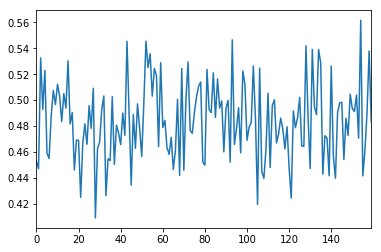

In [31]:
%matplotlib inline
pd.Series(g[0][2]).plot()

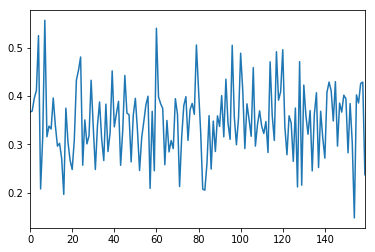

In [22]:
pd.Series(g[1][2]).plot()

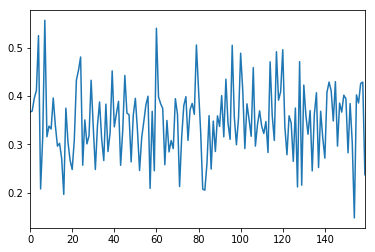

In [23]:
pd.Series(g[1][2]).plot()

In [45]:
np.where(y_train[2] == 1)

(array([120]),)

In [75]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05):
    mx = pred.mean() + 3 * pred.std()
    return np.where(pred > mx)[0]  

In [18]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T
    del(data)

In [26]:
%%time
test_parsed_body = transform_text(test_df)
test_parsed_body_tokens = test_parsed_body.str.split(' ')
testX = test_parsed_body_tokens.map(lambda x: [word2ind.get(i, 0) for i in x])

CPU times: user 4.69 s, sys: 200 ms, total: 4.89 s
Wall time: 4.78 s


In [27]:
x_test = sequence.pad_sequences(testX, maxlen=maxlen)

In [29]:
test_probas = model_lstm.predict_proba(x_test)

7581/7581 [==============================] - 25s    


In [35]:
len(np.where(test_probas > 0.002)[1])

10968

(7581, 3)

In [76]:
%%time
# valid_test_feature_vec found below!

test_values = np.zeros([test_df.shape[0], len(topics)])
for ix, pred in enumerate(test_probas):
    for v in get_classes(pred):
        test_values[ix][v] = 1

test_sub_df = pd.DataFrame(test_values, columns=sorted(topics), index=test_df.index)
# for i in test_feature_vec[test_feature_vec.isnull()].index:
#     test_sub_df.ix[i] = np.zeros(len(topics))

CPU times: user 244 ms, sys: 4 ms, total: 248 ms
Wall time: 225 ms


In [77]:
test_sub_df[test_sub_df.sum(axis=1).isnull()]
test_sub_df.sum(axis=1).sum()

17838.0

In [74]:
test_sub_df.astype(int).reset_index().rename(columns={'index': 'id'}).sort_values('id').to_csv('lstm.2014b_training_700_maxlen_64cell_100epochs_0.0025_threshold.csv', index=False)